In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd

device = torch.device("mps")

In [15]:
# simple tokenization by characters

lines = open('./input.txt', 'r').read()

vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])

print('vocab size:', len(vocab))
decode(encode("hello"))

vocab size: 65


'hello'

In [17]:
dataset = torch.tensor(encode(lines), dtype=torch.int8)

In [4]:
config = {
    "d_model": 100,
    "vocab_size": len(vocab),
    'batch_size': 32,
    'context_window': 10,
}


def get_batches(data, split, batch_size, context_window):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]
    
    batch_data = train
    if split == 'val':
        batch_data = val
    
    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])

[(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

[('s\nFrom me ', '\nFrom me r'),
 ('nnot be\nMi', 'not be\nMin'),
 ('s and me t', ' and me th'),
 ('d am I the', ' am I then'),
 ('.\nTell Bol', '\nTell Boli'),
 (' Citizen:\n', 'Citizen:\nW'),
 ('ht.\nLords,', 't.\nLords, '),
 ('nd for our', 'd for our '),
 ('ns?\nTheref', 's?\nTherefo'),
 (' men are a', 'men are at'),
 ('l.\n\nJULIET', '.\n\nJULIET:'),
 ('a travel t', ' travel th'),
 ("thy day's ", "hy day's w"),
 ('uld have a', 'ld have as'),
 (', but then', ' but then '),
 ('h if I hav', ' if I have'),
 ('How now! w', 'ow now! wh'),
 ('o thy bark', ' thy bark:'),
 ("earn'd eve", "arn'd even"),
 ('mine age,\n', 'ine age,\nA'),
 ('eed; for h', 'ed; for he'),
 ('E:\nNay, co', ':\nNay, com'),
 ('He is, my ', 'e is, my l'),
 ('s thou art', ' thou art '),
 ('y comes ba', ' comes bac'),
 ('n a pile\nO', ' a pile\nOf'),
 (' be that p', 'be that pr'),
 ('and waitin', 'nd waiting'),
 ('ng that:\nS', 'g that:\nSh'),
 ('\nBUCKINGHA', 'BUCKINGHAM'),
 ('brace him;', 'race him; '),
 ('ll men, I '

In [5]:
@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss(model):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

In [6]:
class SwiGLU(nn.Module):
    """
    Swish-Gated Linear Unit
    https://arxiv.org/pdf/2002.05202v1.pdf
    """
    def __init__(self, size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

    def forward(self, x): 
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

In [7]:
class RMSNorm(nn.Module):
    def __init__(self, d, p=-1., eps=1e-8, bias=False):
        """
            Root Mean Square Layer Normalization
        :param d: model size
        :param p: partial RMSNorm, valid value [0, 1], default -1.0 (disabled)
        :param eps:  epsilon value, default 1e-8
        :param bias: whether use bias term for RMSNorm, disabled by
            default because RMSNorm doesn't enforce re-centering invariance.

        https://github.com/bzhangGo/rmsnorm/blob/master/rmsnorm_torch.py
        """
        super(RMSNorm, self).__init__()

        self.eps = eps
        self.d = d
        self.p = p
        self.bias = bias

        self.scale = nn.Parameter(torch.ones(d))
        self.register_parameter("scale", self.scale)

        if self.bias:
            self.offset = nn.Parameter(torch.zeros(d))
            self.register_parameter("offset", self.offset)

    def forward(self, x):
        if self.p < 0. or self.p > 1.:
            norm_x = x.norm(2, dim=-1, keepdim=True)
            d_x = self.d
        else:
            partial_size = int(self.d * self.p)
            partial_x, _ = torch.split(x, [partial_size, self.d - partial_size], dim=-1)

            norm_x = partial_x.norm(2, dim=-1, keepdim=True)
            d_x = partial_size

        rms_x = norm_x * d_x ** (-1. / 2)
        x_normed = x / (rms_x + self.eps)

        if self.bias:
            return self.scale * x_normed + self.offset

        return self.scale * x_normed

tensor([1.3992, 1.4248, 1.1312, 1.0985, 0.9464, 0.8868, 0.8526, 0.7926, 0.7011,
        0.6074], grad_fn=<SumBackward1>)

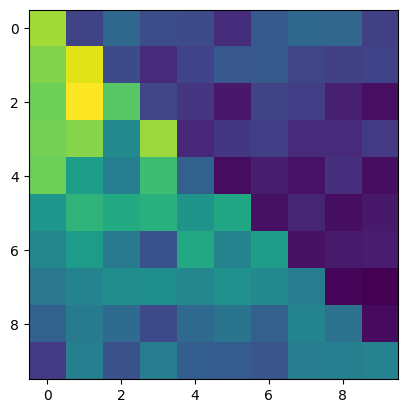

In [8]:
class LlamaAttentionLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'])
        self.w_k = nn.Linear(config['d_model'], config['d_model'])
        self.w_v = nn.Linear(config['d_model'], config['d_model'])

        self.multihead = nn.MultiheadAttention(config['d_model'], config['n_heads'], dropout=0.1, batch_first=True)
        self.rms = RMSNorm(config['d_model'])

    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        activations, attn_weights = self.multihead(q,k,v, attn_mask=torch.tril(torch.ones(m,m)), is_causal=True)
        if return_attn_weights:
            return self.rms(x + activations), attn_weights
        return self.rms(x + activations) # TOOD: this is post-norm, try pre-norm

config = {
    "n_heads": 8,
    "d_model": 128,
}
m = LlamaAttentionLayer(config)
batch = torch.randn(1, 10, config['d_model'])
activations, attn_weights = m(batch, return_attn_weights=True)
plt.imshow(attn_weights.detach().numpy()[0])

attn_weights.squeeze(0).sum(dim=0)

In [9]:
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.attention = LlamaAttentionLayer(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )
        self.rms = RMSNorm(config['d_model'])
    
    def forward(self, x):
        attended = self.attention(x)
        out = self.rms(attended + self.feedforward(attended))
        return out
    
config = {
    "n_heads": 8,
    "d_model": 128,
}
m = LlamaBlock(config)
batch = torch.randn(1, 10, config['d_model'])
m(batch).shape

torch.Size([1, 10, 128])

In [19]:
from collections import OrderedDict

class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])

        self.positional_embeddings = nn.Embedding(config['context_window'], config['d_model'])
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )

        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

    def forward(self, idx, targets=None):
        x = self.embeddings(idx)
        x = x + self.positional_embeddings(torch.arange(x.shape[1])).unsqueeze(0)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits
        
        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        
    def generate(self, idx, max_new_tokens=20):
        for _ in range(max_new_tokens):
            # call the model
            logits = self(idx[:, -config['context_window']:])
            last_time_step_logits = logits[
                :, -1, :
            ]  # all the batches (1), last time step, all the logits
            p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
            idx_next = torch.multinomial(
                p, num_samples=1
            )  # sample from the distribution to get the next token
            idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
        return idx
            
config = {
    "n_heads": 1,
    "d_model": 128,
    "batch_size": 32,
    "n_layers": 1,
    "context_window": 16,
    "vocab_size": len(vocab),
    "epochs": 1000,
    "log_interval": 50,
}
m = Llama(config)
xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
m(xs, targets=ys)

print(f"n params: {sum([p.numel() for p in m.parameters() if p.requires_grad])}")

[decode(x) for x in m.generate(torch.zeros(5, 1).long()).tolist()]

n params: 233665


["\nE$uf'voZYP3PvNLfAnUL",
 '\nPQu\ndwA3IZUpnbaLBpOU',
 '\nz-xFepEKLNTF-zbq;.e;',
 '\nU&WUpbd pYIU:VjBIIQx',
 "\ne?;zpC$I?skae'QhQkX$"]

In [21]:
config = {
    "n_heads": 8,
    "d_model": 128,
    "batch_size": 32,
    "n_layers": 4,
    "context_window": 16,
    "vocab_size": len(vocab),
    "epochs": 10000,
    "log_interval": 50,
}
model = Llama(config)

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=1e-3
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 300, eta_min=1e-5)

losses = []
start_time = time.time()
for epoch in range(config['epochs']):
    optimizer.zero_grad()
    
    xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
    logits, loss = model(xs, targets=ys)
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    
    if epoch % config['log_interval'] == 0:
        batch_time = time.time() - start_time
        x = evaluate_loss(model)
        losses += [x]
        print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
        start_time = time.time()

        print([decode(x) for x in m.generate(torch.zeros(5, 1).long()).tolist()])

pd.DataFrame(losses).plot()

Epoch 0 | val loss 4.170 | Time 0.069 | ETA in seconds 13.823
["\n3E3 3eT'DQ;nz$d-iCXc", "\nWGgpf'IjrHOmaGtwln .", '\nwHrVAXyRj?;hur?.$Rep', '\nw\n\n-uG.x:OVBhd3ZN vu', '\n?DHs.LvCMqKug:3KrjfI']
Epoch 50 | val loss 2.765 | Time 2.263 | ETA in seconds 450.426
["\n.ToZPBT?sBhDt'!NxELq", '\n.nKQExZw3,ZUQHlw;3B,', "\nmE3uj'jLE&WAlmnGejuE", "\nXoGcWbg.OOAUP'yK?fIP", "\n.ZuZN3v-Yn',ChVmsMau"]
Epoch 100 | val loss 1.298 | Time 2.246 | ETA in seconds 444.646
["\noBjRuk?st'WhQCO:kq&n", '\n3lstES!Owm$rOU,mMpum', "\nR,Y;bVoJlrYbfIEH'!Jd", '\n-MrEmHCuk-P.lYHh YL:', '\nB,S:SlxtqGi$hMr.bF:U']
Epoch 150 | val loss 0.271 | Time 2.273 | ETA in seconds 447.827
['\neGsCm\n!p;Ez3;LjEBwqW', '\nA$-ZqpF-c.wJTDX3\nXhd', '\nCD:CuoZcPHXPn-\ngM;AU', '\nqsDwRZRv$YvAcKJ.ODc.', '\nH$ptAaVr-&ZsxShcq$CA']
Epoch 200 | val loss 0.181 | Time 2.245 | ETA in seconds 439.993
['\nWZXuDIwBI LOou?NWfmk', '\nucNYwIhXGLtC.MQsvnWP', '\nu,jQttCjQYPb sbL&aFZ', '\nI-ixaQ?a&a L zl?MaNN', "\nnnIXjF$TJzkArv-'ufiU"]
Epoch 250 | val los

KeyboardInterrupt: 

In [ ]:
def generate(model, idx, max_length=10):
    x = idx
    with torch.no_grad():
        for _ in range(max_length):
            sequence = x[:, -model.config['context_window']:]
            logits = model(sequence)[:,-1, :]
            probs = F.softmax(logits, dim=-1)
            pred = torch.multinomial(probs, 1, replacement=True)
            x = torch.cat([x, pred], dim=-1)
        return x

[decode(x) for x in generate(model, torch.randint(0, len(vocab), (5, 1)).long()).tolist()]

['KKKKKKKKKKK', 'TTTTTTTTTTT', 'ggggggggggg', 'HHHHHHGHHHH', 'IIIIIIIIIII']